## Reload the `EC_estimator.py` code to consider any changes

In [1]:
#reload model magic
%load_ext autoreload
%autoreload 2

import EC_estimator as annec

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [3]:
tf.__version__

'2.2.0'

## Train All 12 EC Target Stations

Run the cell below to train models for all 12 EC stations sequentially. Each model will be saved in its own folder under `Export/`.

**Stations:** CVP_INTAKE_EC, MIDR_INTAKE_EC, OLDR_CCF_EC, ROLD024_EC, RSAC054_EC, RSAC081_EC, RSAC092_EC, RSAN007_EC, RSAN018_EC, SLMZU003_EC, SLMZU011_EC, VICT_INTAKE_EC

In [ ]:
# Train models for ALL target stations
# This cell will loop through each station and train a separate model

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import EC_estimator as annec
import tensorflow as tf

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]

target_stations = [
    "CVP_INTAKE_EC", "MIDR_INTAKE_EC", "OLDR_CCF_EC", "ROLD024_EC",
    "RSAC054_EC", "RSAC081_EC", "RSAC092_EC", "RSAN007_EC",
    "RSAN018_EC", "SLMZU003_EC", "SLMZU011_EC", "VICT_INTAKE_EC"
]

dataset_files = [
    "Inputs/data_base.csv",
    "Inputs/data_base_ns.csv",
    "Inputs/data_6k_tunnel.csv"
]

WINDOW = 118
test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"
calib_prop = 0.8

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def load_and_preprocess_dataset(filepath):
    df = pd.read_csv(filepath, index_col=0)
    df = df.reset_index()
    df.columns = ["date"] + list(df.columns[1:])
    df["date"] = pd.to_datetime(df["date"], errors="raise")
    df = df.sort_values("date")
    df = df.reset_index(drop=True)
    return df

def make_windows(df_raw, predictors, target, window):
    X_all = df_raw[predictors].to_numpy()
    y_all = df_raw[target].to_numpy().reshape(-1, 1)
    if len(df_raw) < window:
        raise ValueError(f"Not enough rows ({len(df_raw)}) to build a window of {window}.")
    Xw, yw = [], []
    for t in range(window - 1, len(df_raw)):
        Xw.append(X_all[t - window + 1 : t + 1, :])
        yw.append(y_all[t])
    return np.stack(Xw, axis=0), np.vstack(yw)

# ------------------------------------------------------------
# Load datasets once
# ------------------------------------------------------------
print("Loading datasets...")
datasets = {fp.split("/")[-1].replace(".csv", ""): load_and_preprocess_dataset(fp) for fp in dataset_files}

datasets_test_raw = {}
datasets_train_full_raw = {}
for name, df in datasets.items():
    datasets_test_raw[name] = df[(df["date"] >= test_start) & (df["date"] <= test_end)].copy()
    datasets_train_full_raw[name] = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()

df_train_full_combined = pd.concat([datasets_train_full_raw[name] for name in datasets.keys()], ignore_index=True)

# Store results for all stations
all_results = []

# ------------------------------------------------------------
# Train each station
# ------------------------------------------------------------
for station_idx, target in enumerate(target_stations):
    print(f"\n{'='*80}")
    print(f"TRAINING STATION {station_idx + 1}/{len(target_stations)}: {target}")
    print(f"{'='*80}")
    
    np.random.seed(42)  # Reset seed for reproducibility
    
    # Build windows and combine datasets
    X_train_combined, y_train_combined = [], []
    X_val_combined, y_val_combined = [], []
    X_test_combined, y_test_combined = [], []
    
    for name in datasets.keys():
        X_train_full_seq, y_train_full_arr = make_windows(datasets_train_full_raw[name], predictors, target, WINDOW)
        X_test_seq, y_test_arr = make_windows(datasets_test_raw[name], predictors, target, WINDOW)
        
        n_train_samples = X_train_full_seq.shape[0]
        vset = np.random.rand(n_train_samples)
        train_mask = vset < calib_prop
        val_mask = vset >= calib_prop
        
        X_train_combined.append(X_train_full_seq[train_mask])
        y_train_combined.append(y_train_full_arr[train_mask])
        X_val_combined.append(X_train_full_seq[val_mask])
        y_val_combined.append(y_train_full_arr[val_mask])
        X_test_combined.append(X_test_seq)
        y_test_combined.append(y_test_arr)
    
    X_train_seq = np.concatenate(X_train_combined, axis=0)
    y_train_arr = np.concatenate(y_train_combined, axis=0)
    X_val_seq = np.concatenate(X_val_combined, axis=0)
    y_val_arr = np.concatenate(y_val_combined, axis=0)
    X_test_seq = np.concatenate(X_test_combined, axis=0)
    y_test_arr = np.concatenate(y_test_combined, axis=0)
    
    print(f"Train: {X_train_seq.shape[0]}, Val: {X_val_seq.shape[0]}, Test: {X_test_seq.shape[0]}")
    
    # Format inputs
    X_train = [X_train_seq[:, :, i] for i in range(len(predictors))]
    X_val = [X_val_seq[:, :, i] for i in range(len(predictors))]
    X_test = [X_test_seq[:, :, i] for i in range(len(predictors))]
    
    y_train = pd.DataFrame(y_train_arr, columns=[target])
    y_val = pd.DataFrame(y_val_arr, columns=[target])
    y_test = pd.DataFrame(y_test_arr, columns=[target])
    
    # Build and train model
    inputs = annec.build_model_inputs(None)
    layers = annec.preprocessing_layers(df_train_full_combined, inputs, X_train)
    model, tensorboard_cb = annec.build_model(layers, inputs, y_train=y_train)
    
    y_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    y_train_scaled = y_scaler.fit_transform(y_train.values)
    y_val_scaled = y_scaler.transform(y_val.values)
    y_test_scaled = y_scaler.transform(y_test.values)
    
    history, model = annec.train_model(
        model, tensorboard_cb,
        X_train, y_train_scaled,
        X_val, y_val_scaled,
        epochs=2000, patience=1000, batch_size=128  # Set to 50 for testing, increase to 1000+ for production
    )
    
    # Create inference model and evaluate
    inference_model = annec.create_inference_model(model)
    y_train_pred = inference_model.predict(X_train, verbose=0)
    y_val_pred = inference_model.predict(X_val, verbose=0)
    y_test_pred = inference_model.predict(X_test, verbose=0)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train.values, y_train_pred))
    train_r2 = r2_score(y_train.values, y_train_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val.values, y_val_pred))
    val_r2 = r2_score(y_val.values, y_val_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test.values, y_test_pred))
    test_r2 = r2_score(y_test.values, y_test_pred)
    
    print(f"\n{target} Results:")
    print(f"  Train - RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"  Val   - RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")
    print(f"  Test  - RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")
    
    all_results.append({
        'Station': target,
        'Train_Samples': len(y_train),
        'Val_Samples': len(y_val),
        'Test_Samples': len(y_test),
        'Train_RMSE': train_rmse, 
        'Train_R2': train_r2,
        'Val_RMSE': val_rmse, 
        'Val_R2': val_r2,
        'Test_RMSE': test_rmse, 
        'Test_R2': test_r2,
        'y_train_min': y_train.values.min(),
        'y_train_max': y_train.values.max(),
        'y_test_min': y_test.values.min(),
        'y_test_max': y_test.values.max()
    })
    
    # Save models
    model_save_path = f'./Export/{target}'
    os.makedirs(model_save_path, exist_ok=True)
    annec.save_model(model, model_save_path)
    inference_model.save(os.path.join(model_save_path, 'inference_model'))
    print(f"  Model saved to: {model_save_path}")
    
    # Clear session to free memory
    tf.keras.backend.clear_session()

# ------------------------------------------------------------
# Summary table and save results
# ------------------------------------------------------------
print(f"\n{'='*80}")
print("SUMMARY OF ALL STATIONS")
print(f"{'='*80}")
results_df = pd.DataFrame(all_results)

# Display key metrics
display_cols = ['Station', 'Train_R2', 'Val_R2', 'Test_R2', 'Train_RMSE', 'Val_RMSE', 'Test_RMSE']
print(results_df[display_cols].to_string(index=False))

# Save full results to CSV
os.makedirs("Export", exist_ok=True)
results_df.to_csv("Export/all_stations_results.csv", index=False)
print(f"\n✓ Full results saved to: Export/all_stations_results.csv")
print(f"  Columns: {list(results_df.columns)}")

Loading datasets...

TRAINING STATION 1/12: CVP_INTAKE_EC
Train: 65955, Val: 16422, Test: 18276

CVP_INTAKE_EC Results:
  Train - RMSE: 29.98, R²: 0.9670
  Val   - RMSE: 30.34, R²: 0.9665
  Test  - RMSE: 47.07, R²: 0.9004
INFO:tensorflow:Assets written to: ./Export/CVP_INTAKE_EC\assets
Model saved at location: ./Export/CVP_INTAKE_EC
INFO:tensorflow:Assets written to: ./Export/CVP_INTAKE_EC\inference_model\assets
  Model saved to: ./Export/CVP_INTAKE_EC

TRAINING STATION 2/12: MIDR_INTAKE_EC
Train: 65955, Val: 16422, Test: 18276

MIDR_INTAKE_EC Results:
  Train - RMSE: 23.39, R²: 0.9604
  Val   - RMSE: 23.98, R²: 0.9591
  Test  - RMSE: 33.79, R²: 0.9092
INFO:tensorflow:Assets written to: ./Export/MIDR_INTAKE_EC\assets
Model saved at location: ./Export/MIDR_INTAKE_EC
INFO:tensorflow:Assets written to: ./Export/MIDR_INTAKE_EC\inference_model\assets
  Model saved to: ./Export/MIDR_INTAKE_EC

TRAINING STATION 3/12: OLDR_CCF_EC
Train: 65955, Val: 16422, Test: 18276

OLDR_CCF_EC Results:
  Tr

## [OPTIONAL] Train Single Station with Detailed Plots

Use this section when you want to train just ONE station and see detailed visualizations (scatter plots, time series, monthly aggregation). Skip this if you already ran the "Train All 12 Stations" cell above.

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import EC_estimator as annec
import tensorflow as tf

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]

# All target EC stations to train models for
target_stations = [
    "CVP_INTAKE_EC", "MIDR_INTAKE_EC", "OLDR_CCF_EC", "ROLD024_EC",
    "RSAC054_EC", "RSAC081_EC", "RSAC092_EC", "RSAN007_EC",
    "RSAN018_EC", "SLMZU003_EC", "SLMZU011_EC", "VICT_INTAKE_EC"
]

# Dataset files to combine
dataset_files = [
    "Inputs/data_base.csv",
    "Inputs/data_base_ns.csv",
    "Inputs/data_6k_tunnel.csv"
]

WINDOW = 118  # 1 + 7 + (10*11)

test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"

# Calibration proportion for train/validation split
calib_prop = 0.8  # 80% of training data for calibration, 20% for validation


# ------------------------------------------------------------
# Helper: create sliding windows
# ------------------------------------------------------------
def make_windows(df_raw: pd.DataFrame, predictors, target, window: int):
    """
    Builds:
      X_seq: (N, window, n_predictors)
      y:     (N, 1)

    Backward alignment:
      window rows are [t-window+1, ..., t]  (history ending at t)
      y is df_raw[target].iloc[t]
    """
    X_all = df_raw[predictors].to_numpy()
    y_all = df_raw[target].to_numpy().reshape(-1, 1)

    if len(df_raw) < window:
        raise ValueError(f"Not enough rows ({len(df_raw)}) to build a window of {window}.")

    Xw = []
    yw = []

    # t is the "current day" index
    for t in range(window - 1, len(df_raw)):
        Xw.append(X_all[t - window + 1 : t + 1, :])  # (window, n_predictors), ends at t
        yw.append(y_all[t])                          # target at t

    X_seq = np.stack(Xw, axis=0)
    y = np.vstack(yw)
    return X_seq, y


# ------------------------------------------------------------
# Helper: Load and preprocess a single dataset
# ------------------------------------------------------------
def load_and_preprocess_dataset(filepath):
    """Load a dataset file and prepare it for training."""
    df = pd.read_csv(filepath, index_col=0)
    df = df.reset_index()
    df.columns = ["date"] + list(df.columns[1:])
    df["date"] = pd.to_datetime(df["date"], errors="raise")
    df = df.sort_values("date")
    df = df.reset_index(drop=True)
    return df


# ------------------------------------------------------------
# Load all three datasets
# ------------------------------------------------------------
print("Loading datasets...")
datasets = {}
for filepath in dataset_files:
    name = filepath.split("/")[-1].replace(".csv", "")
    datasets[name] = load_and_preprocess_dataset(filepath)
    print(f"  {name}: {len(datasets[name])} rows, date range: {datasets[name]['date'].min().date()} to {datasets[name]['date'].max().date()}")

# Sanity check columns
for name, df in datasets.items():
    missing_cols = [c for c in (["date"] + predictors + target_stations) if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in {name}: {missing_cols}")

print(f"\nPredictors: {predictors}")
print(f"Target stations: {target_stations}")


# ------------------------------------------------------------
# Split each dataset by date ranges
# ------------------------------------------------------------
print("\n" + "="*60)
print("Splitting datasets by date ranges...")
print("="*60)

datasets_test_raw = {}
datasets_train_full_raw = {}

for name, df in datasets.items():
    df_test_raw = df[(df["date"] >= test_start) & (df["date"] <= test_end)].copy()
    df_train_full_raw = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()
    
    if df_test_raw.empty:
        raise ValueError(f"{name}: df_test_raw is empty. Check that dates exist in 1923–1939.")
    if df_train_full_raw.empty:
        raise ValueError(f"{name}: df_train_full_raw is empty. Check that dates exist in 1940–2015.")
    
    datasets_test_raw[name] = df_test_raw
    datasets_train_full_raw[name] = df_train_full_raw
    
    print(f"\n{name}:")
    print(f"  Test : {df_test_raw['date'].min().date()} → {df_test_raw['date'].max().date()}, rows: {len(df_test_raw)}")
    print(f"  Train: {df_train_full_raw['date'].min().date()} → {df_train_full_raw['date'].max().date()}, rows: {len(df_train_full_raw)}")


# ------------------------------------------------------------
# SELECT TARGET STATION FOR THIS TRAINING RUN
# ------------------------------------------------------------
# Available stations (change the index 0-11 to select a different station):
#   0: CVP_INTAKE_EC      1: MIDR_INTAKE_EC     2: OLDR_CCF_EC
#   3: ROLD024_EC         4: RSAC054_EC         5: RSAC081_EC
#   6: RSAC092_EC         7: RSAN007_EC         8: RSAN018_EC
#   9: SLMZU003_EC       10: SLMZU011_EC       11: VICT_INTAKE_EC
# ------------------------------------------------------------
STATION_INDEX = 4  # <-- CHANGE THIS NUMBER (0-11) TO SELECT A DIFFERENT STATION
# ------------------------------------------------------------

target = target_stations[STATION_INDEX]

print(f"\n{'='*60}")
print(f"SELECTED TARGET STATION: {target}")
print(f"(Station index: {STATION_INDEX} of {len(target_stations)-1})")
print(f"{'='*60}")
print(f"\nTo train a different station, change STATION_INDEX above.")


# ------------------------------------------------------------
# Build windows for each dataset, then combine
# Apply calib_prop split to each dataset BEFORE combining
# ------------------------------------------------------------
print("\nBuilding windows and applying train/val split for each dataset...")

np.random.seed(42)  # For reproducibility

X_train_combined = []
y_train_combined = []
X_val_combined = []
y_val_combined = []
X_test_combined = []
y_test_combined = []

# Track dates for monthly aggregation
train_dates_combined = []
val_dates_combined = []
test_dates_combined = []

for name in datasets.keys():
    df_train_full_raw = datasets_train_full_raw[name]
    df_test_raw = datasets_test_raw[name]
    
    # Create windows
    X_train_full_seq, y_train_full_arr = make_windows(df_train_full_raw, predictors, target, WINDOW)
    X_test_seq, y_test_arr = make_windows(df_test_raw, predictors, target, WINDOW)
    
    # Apply calib_prop split to THIS dataset's training windows
    n_train_samples = X_train_full_seq.shape[0]
    vset = np.random.rand(n_train_samples)
    train_mask = vset < calib_prop
    val_mask = vset >= calib_prop
    
    # Apply the mask to get train and validation sets
    X_train_seq = X_train_full_seq[train_mask]
    y_train_arr = y_train_full_arr[train_mask]
    X_val_seq = X_train_full_seq[val_mask]
    y_val_arr = y_train_full_arr[val_mask]
    
    # Get dates for windows (window ends at each date)
    train_full_dates = df_train_full_raw["date"].iloc[WINDOW-1:].reset_index(drop=True)
    test_window_dates = df_test_raw["date"].iloc[WINDOW-1:].reset_index(drop=True)
    
    print(f"\n{name}:")
    print(f"  Train windows: {X_train_seq.shape[0]} ({X_train_seq.shape[0]/n_train_samples*100:.1f}%)")
    print(f"  Val windows  : {X_val_seq.shape[0]} ({X_val_seq.shape[0]/n_train_samples*100:.1f}%)")
    print(f"  Test windows : {X_test_seq.shape[0]}")
    
    # Append to combined lists
    X_train_combined.append(X_train_seq)
    y_train_combined.append(y_train_arr)
    X_val_combined.append(X_val_seq)
    y_val_combined.append(y_val_arr)
    X_test_combined.append(X_test_seq)
    y_test_combined.append(y_test_arr)
    
    # Append dates for monthly aggregation
    train_dates_combined.append(train_full_dates[train_mask].reset_index(drop=True))
    val_dates_combined.append(train_full_dates[val_mask].reset_index(drop=True))
    test_dates_combined.append(test_window_dates)

# Combine all datasets
X_train_seq = np.concatenate(X_train_combined, axis=0)
y_train_arr = np.concatenate(y_train_combined, axis=0)
X_val_seq = np.concatenate(X_val_combined, axis=0)
y_val_arr = np.concatenate(y_val_combined, axis=0)
X_test_seq = np.concatenate(X_test_combined, axis=0)
y_test_arr = np.concatenate(y_test_combined, axis=0)

# Combine dates
train_dates_all = pd.concat(train_dates_combined, ignore_index=True)
val_dates_all = pd.concat(val_dates_combined, ignore_index=True)
test_dates_all = pd.concat(test_dates_combined, ignore_index=True)

print(f"\n{'='*60}")
print("COMBINED DATASETS:")
print(f"{'='*60}")
print(f"Total Train windows: {X_train_seq.shape[0]}")
print(f"Total Val windows  : {X_val_seq.shape[0]}")
print(f"Total Test windows : {X_test_seq.shape[0]}")

# Convert to "7 inputs" format: each is (N,118)
X_train = [X_train_seq[:, :, i] for i in range(len(predictors))]
X_val = [X_val_seq[:, :, i] for i in range(len(predictors))]
X_test = [X_test_seq[:, :, i] for i in range(len(predictors))]

# Targets as DataFrame
y_train = pd.DataFrame(y_train_arr, columns=[target])
y_val = pd.DataFrame(y_val_arr, columns=[target])
y_test = pd.DataFrame(y_test_arr, columns=[target])

print("\nX_train shapes:", [x.shape for x in X_train])  # expect 7 × (N,118)
print("X_val shapes  :", [x.shape for x in X_val])
print("X_test shapes :", [x.shape for x in X_test])
print("\ny_train shape :", y_train.shape)
print("y_val shape   :", y_val.shape)
print("y_test shape  :", y_test.shape)
print(f"\ny_train range (original): [{y_train.values.min():.1f}, {y_train.values.max():.1f}]")
print(f"y_val range (original)  : [{y_val.values.min():.1f}, {y_val.values.max():.1f}]")
print(f"y_test range (original) : [{y_test.values.min():.1f}, {y_test.values.max():.1f}]")
# ------------------------------------------------------------

# ------------------------------------------------------------
# Combine full training data for normalization statistics

df_train_full_combined = pd.concat([datasets_train_full_raw[name] for name in datasets.keys()], ignore_index=True)
print(f"\nCombined training data for normalization: {len(df_train_full_combined)} rows")
# ------------------------------------------------------------

# ------------------------------------------------------------
# Build model
# Model outputs predictions in SCALED space [0.1, 0.9]
# For inference in original units, use create_inference_model()
# ------------------------------------------------------------
inputs = annec.build_model_inputs(None)

# Preprocessing layers: antecedent extraction + z-score normalization (embedded in model)
# Use combined full training data for computing normalization statistics
layers = annec.preprocessing_layers(df_train_full_combined, inputs, X_train)

print(f"\nBuilt {len(layers)} input preprocessing layers")

# Build model - stores scaling parameters but doesn't use them during training
model, tensorboard_cb = annec.build_model(layers, inputs, y_train=y_train)


model.summary()

# Scale targets to [0.1, 0.9] for training using sklearn (proven to work well)
y_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
y_train_scaled = y_scaler.fit_transform(y_train.values)
y_val_scaled = y_scaler.transform(y_val.values)
y_test_scaled = y_scaler.transform(y_test.values)

print(f"\nScaled y_train range: [{y_train_scaled.min():.4f}, {y_train_scaled.max():.4f}]")
print(f"Scaled y_val range  : [{y_val_scaled.min():.4f}, {y_val_scaled.max():.4f}]")
print(f"Scaled y_test range : [{y_test_scaled.min():.4f}, {y_test_scaled.max():.4f}]")

# ------------------------------------------------------------
# Train model
# Model learns to output directly in scaled space [0.1, 0.9]
# ------------------------------------------------------------
history, model = annec.train_model(
    model, tensorboard_cb, 
    X_train, y_train_scaled,    # Scaled targets [0.1, 0.9]
    X_val, y_val_scaled,        # Scaled validation [0.1, 0.9]
    epochs=1000,
    patience=1000,
    batch_size=128
)

Loading datasets...
  data_base: 34180 rows, date range: 1921-12-02 to 2015-07-01
  data_base_ns: 34180 rows, date range: 1921-12-02 to 2015-07-01
  data_6k_tunnel: 34180 rows, date range: 1921-12-02 to 2015-07-01

Predictors: ['dcc', 'exports', 'sac', 'sjr', 'tide', 'net_dcd', 'smscg']
Target stations: ['CVP_INTAKE_EC', 'MIDR_INTAKE_EC', 'OLDR_CCF_EC', 'ROLD024_EC', 'RSAC054_EC', 'RSAC081_EC', 'RSAC092_EC', 'RSAN007_EC', 'RSAN018_EC', 'SLMZU003_EC', 'SLMZU011_EC', 'VICT_INTAKE_EC']

Splitting datasets by date ranges...

data_base:
  Test : 1923-01-01 → 1939-12-31, rows: 6209
  Train: 1940-01-01 → 2015-07-01, rows: 27576

data_base_ns:
  Test : 1923-01-01 → 1939-12-31, rows: 6209
  Train: 1940-01-01 → 2015-07-01, rows: 27576

data_6k_tunnel:
  Test : 1923-01-01 → 1939-12-31, rows: 6209
  Train: 1940-01-01 → 2015-07-01, rows: 27576

SELECTED TARGET STATION: RSAC054_EC
(Station index: 4 of 11)

To train a different station, change STATION_INDEX above.

Building windows and applying train

## Evaluation of the model

In [40]:
# Calculate metrics for ANN
# The trained model outputs scaled predictions [0.1, 0.9]
# We create an inference model that automatically inverse-transforms to original units

metrics = []

# Predict with trained model (outputs are scaled [0.1, 0.9])
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_val_pred_scaled = model.predict(X_val, verbose=0)
y_test_pred_scaled  = model.predict(X_test, verbose=0)

# Create inference model with automatic inverse scaling
inference_model = annec.create_inference_model(model)

# Predict with inference model (outputs are original units)
y_train_pred = inference_model.predict(X_train, verbose=0)
y_val_pred = inference_model.predict(X_val, verbose=0)
y_test_pred  = inference_model.predict(X_test, verbose=0)

print("=== Predictions (original EC units, last 3 samples) ===")
print("train:", y_train_pred[-3:].ravel())
print("val  :", y_val_pred[-3:].ravel())
print("test :", y_test_pred[-3:].ravel())

print("\n=== Scaled predictions range ===")
print(f"y_train_pred_scaled: [{y_train_pred_scaled.min():.4f}, {y_train_pred_scaled.max():.4f}]")
print(f"y_val_pred_scaled  : [{y_val_pred_scaled.min():.4f}, {y_val_pred_scaled.max():.4f}]")
print(f"y_test_pred_scaled : [{y_test_pred_scaled.min():.4f}, {y_test_pred_scaled.max():.4f}]")

print("\n=== Original unit predictions range ===")
print(f"y_train_pred: [{y_train_pred.min():.1f}, {y_train_pred.max():.1f}]")
print(f"y_val_pred  : [{y_val_pred.min():.1f}, {y_val_pred.max():.1f}]")
print(f"y_test_pred : [{y_test_pred.min():.1f}, {y_test_pred.max():.1f}]")

# Compute metrics using original (unscaled) values
y_train_true = y_train.values  # Original EC values
y_val_true = y_val.values      # Original EC values
y_test_true  = y_test.values   # Original EC values

metrics.append(
    annec.calculate_metrics("ANN", y_train, y_train_pred, y_test, y_test_pred)
)

df3 = pd.DataFrame(metrics)
print("\n=== Model Performance ===")
print(df3)

# Additional validation metrics
print("\n=== Validation Set Metrics ===")
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_r2 = r2_score(y_val_true, y_val_pred)
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation R²  : {val_r2:.4f}")

=== Predictions (original EC units, last 3 samples) ===
train: [21154.42  21310.262 21385.191]
val  : [20438.264 20246.38  19911.602]
test : [25162.396 24763.049 24264.35 ]

=== Scaled predictions range ===
y_train_pred_scaled: [0.1321, 0.8974]
y_val_pred_scaled  : [0.1350, 0.8983]
y_test_pred_scaled : [0.1334, 0.8996]

=== Original unit predictions range ===
y_train_pred: [1548.4, 27681.1]
y_val_pred  : [1648.9, 27714.0]
y_test_pred : [1595.5, 27757.2]

=== Model Performance ===
  Model  Train_R2  Train_RMSE  Train_Percentage_Bias  Test_R2  Test_RMSE  \
0   ANN     0.998      382.55                   1.32    0.993     598.24   

   Test_Percentage_Bias  
0                  -0.6  

=== Validation Set Metrics ===
Validation RMSE: 392.05
Validation R²  : 0.9975


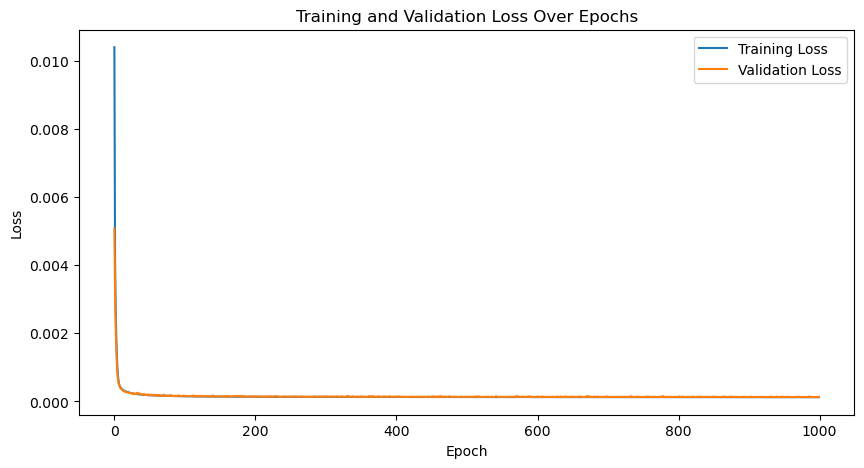

In [41]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

Last prediction: 24264.3


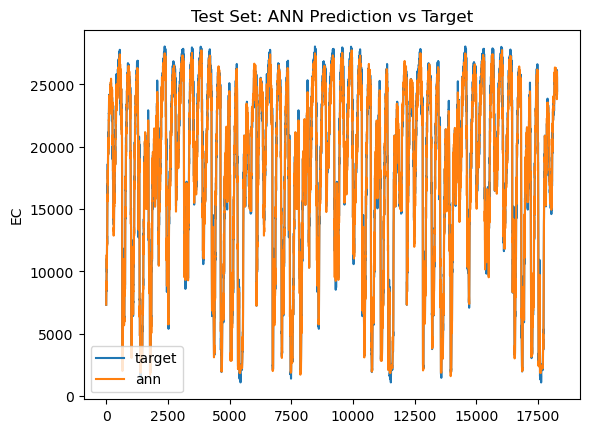

In [42]:
# Plot predictions vs actual (in original EC units)
import matplotlib.pyplot as plt

ax = y_test.plot(label='target')
pred = pd.DataFrame(index=y_test.index, data=y_test_pred, columns=['prediction'])
print(f"Last prediction: {pred.iloc[-1].values[0]:.1f}")
pred.plot(ax=ax)
plt.ylabel('EC')
plt.legend(["target", "ann"])
plt.title('Test Set: ANN Prediction vs Target')
plt.show()

## Target vs ANN predictions scatter plot

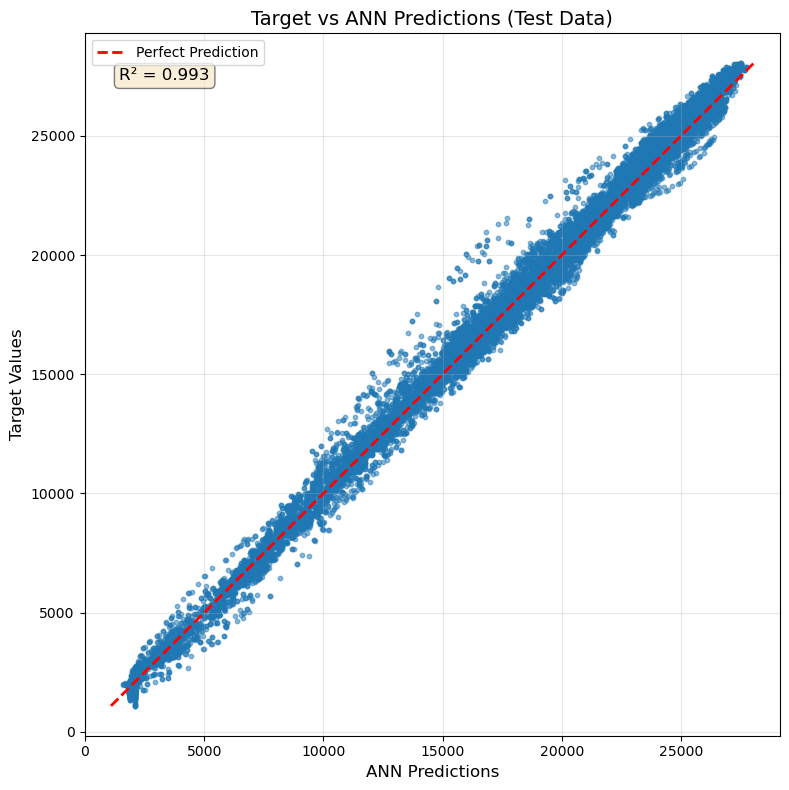

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for test data
y_test_np = y_test.values.ravel()
y_test_pred_np = y_test_pred.ravel()
r2_test = r2_score(y_test_np, y_test_pred_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_pred_np, y_test_np, alpha=0.5, s=10)

# Add diagonal line (perfect prediction)
min_val = min(y_test_np.min(), y_test_pred_np.min())
max_val = max(y_test_np.max(), y_test_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_test:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions', fontsize=12)
plt.ylabel('Target Values', fontsize=12)
plt.title('Target vs ANN Predictions (Test Data)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Training Data: Target vs ANN predictions scatter plot

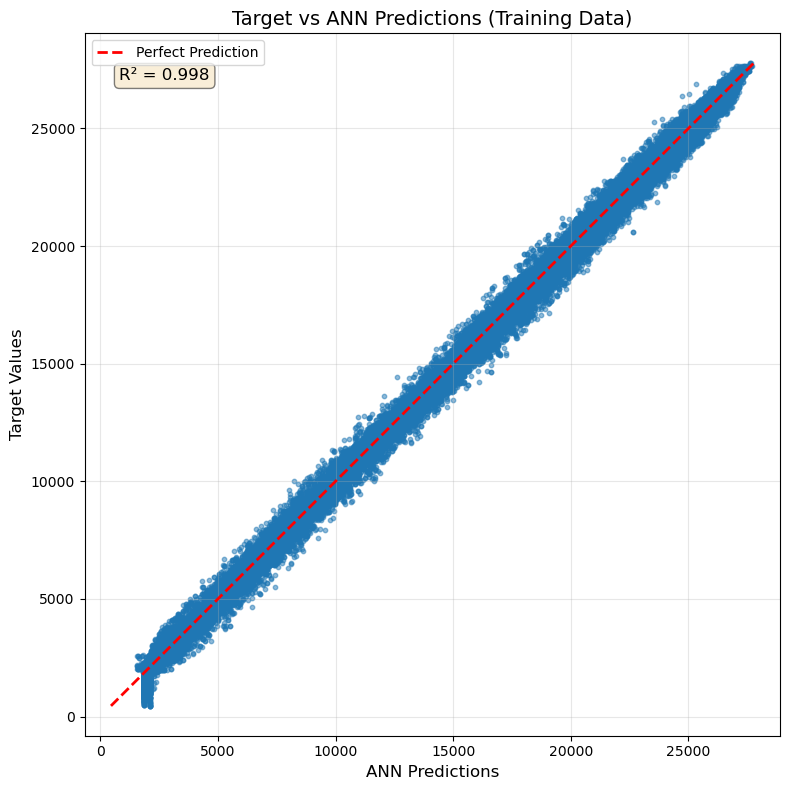

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for training data
y_train_np = y_train.values.ravel()
y_train_pred_np = y_train_pred.ravel()
r2_train = r2_score(y_train_np, y_train_pred_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train_pred_np, y_train_np, alpha=0.5, s=10)

# Add diagonal line (perfect prediction)
min_val = min(y_train_np.min(), y_train_pred_np.min())
max_val = max(y_train_np.max(), y_train_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_train:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions', fontsize=12)
plt.ylabel('Target Values', fontsize=12)
plt.title('Target vs ANN Predictions (Training Data)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Monthly aggregated data analysis

In [45]:
# Add date indices to DataFrames for monthly aggregation
# Dates were tracked during dataset combination in the training cell
# train_dates_all, val_dates_all, test_dates_all are combined from all 3 datasets

# Set date indices on target DataFrames
y_train_with_dates = y_train.copy()
y_train_with_dates.index = pd.to_datetime(train_dates_all)
y_test_with_dates = y_test.copy()
y_test_with_dates.index = pd.to_datetime(test_dates_all)

# Create DataFrames with predictions and date indices
y_train_pred_df = pd.DataFrame(index=pd.to_datetime(train_dates_all), data=y_train_pred, columns=['emm_ec_pred'])
y_test_pred_df = pd.DataFrame(index=pd.to_datetime(test_dates_all), data=y_test_pred, columns=['emm_ec_pred'])

# Monthly aggregation - using mean
y_train_monthly = y_train_with_dates.resample('M').mean()
y_train_pred_monthly = y_train_pred_df.resample('M').mean()

y_test_monthly = y_test_with_dates.resample('M').mean()
y_test_pred_monthly = y_test_pred_df.resample('M').mean()

print("Training Data - Monthly Averages")
print(f"Number of months: {len(y_train_monthly)}")
print(f"Date range: {y_train_monthly.index.min().date()} to {y_train_monthly.index.max().date()}")
print(y_train_monthly.head())

print("\nTest Data - Monthly Averages")
print(f"Number of months: {len(y_test_monthly)}")
print(f"Date range: {y_test_monthly.index.min().date()} to {y_test_monthly.index.max().date()}")
print(y_test_monthly.head())

Training Data - Monthly Averages
Number of months: 904
Date range: 1940-04-30 to 2015-07-31
              RSAC054_EC
date                    
1940-04-30   3267.743308
1940-05-31   8719.940352
1940-06-30  15353.171960
1940-07-31  17890.224164
1940-08-31  20217.427777

Test Data - Monthly Averages
Number of months: 201
Date range: 1923-04-30 to 1939-12-31
              RSAC054_EC
date                    
1923-04-30   7462.980719
1923-05-31   9946.862070
1923-06-30  15538.422591
1923-07-31  19581.541272
1923-08-31  22572.368216


## Monthly Training Data: Time Series Plot

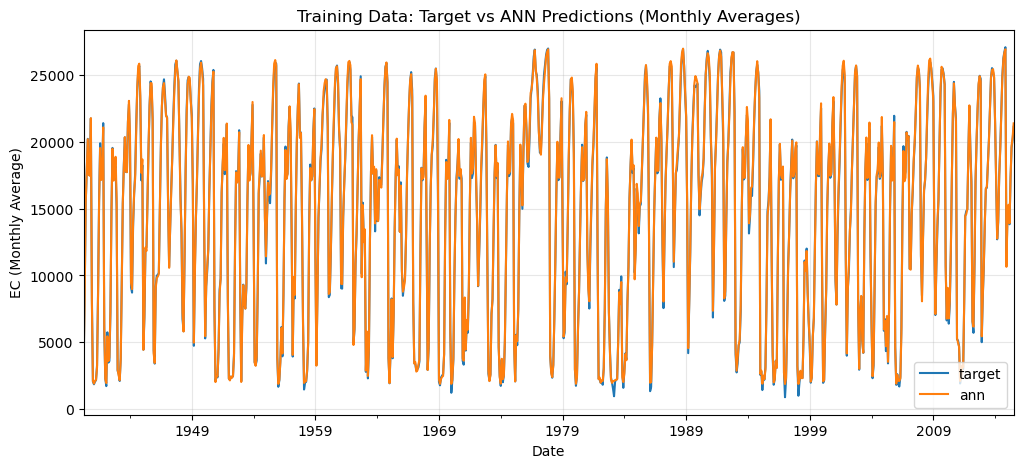

In [46]:
import matplotlib.pyplot as plt

ax = y_train_monthly.plot(figsize=(12, 5))
y_train_pred_monthly.plot(ax=ax)
plt.legend(["target", "ann"])
plt.title('Training Data: Target vs ANN Predictions (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('EC (Monthly Average)')
plt.grid(True, alpha=0.3)
plt.show()

## Monthly Training Data: Scatter Plot with R²

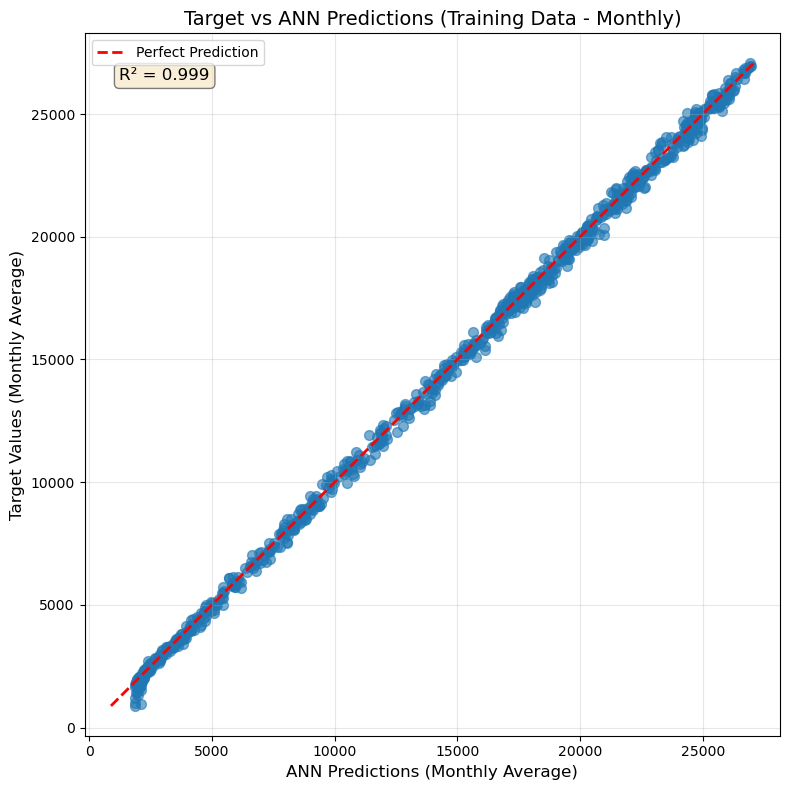

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for monthly training data
y_train_monthly_np = y_train_monthly.values.ravel()
y_train_pred_monthly_np = y_train_pred_monthly.values.ravel()
r2_train_monthly = r2_score(y_train_monthly_np, y_train_pred_monthly_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train_pred_monthly_np, y_train_monthly_np, alpha=0.6, s=50)

# Add diagonal line (perfect prediction)
min_val = min(y_train_monthly_np.min(), y_train_pred_monthly_np.min())
max_val = max(y_train_monthly_np.max(), y_train_pred_monthly_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_train_monthly:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions (Monthly Average)', fontsize=12)
plt.ylabel('Target Values (Monthly Average)', fontsize=12)
plt.title('Target vs ANN Predictions (Training Data - Monthly)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Monthly Test Data: Time Series Plot

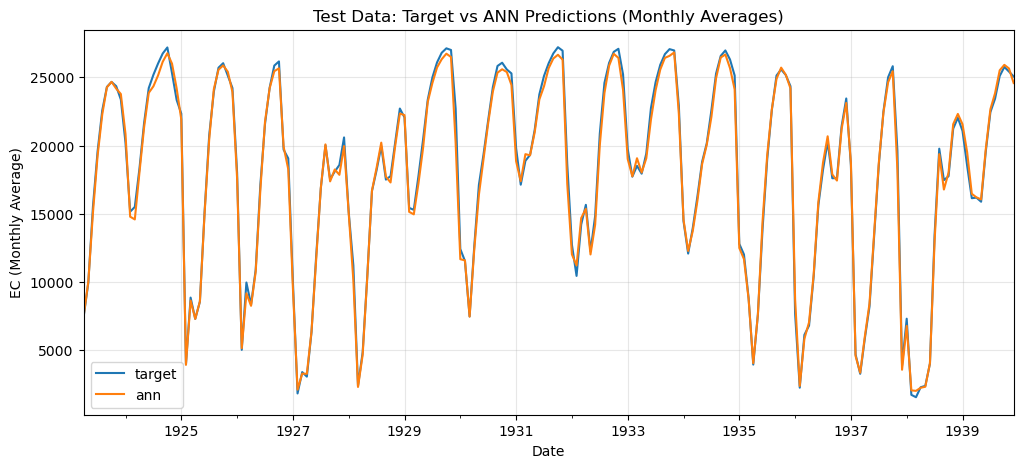

In [48]:
import matplotlib.pyplot as plt

ax = y_test_monthly.plot(figsize=(12, 5))
y_test_pred_monthly.plot(ax=ax)
plt.legend(["target", "ann"])
plt.title('Test Data: Target vs ANN Predictions (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('EC (Monthly Average)')
plt.grid(True, alpha=0.3)
plt.show()

## Monthly Test Data: Scatter Plot with R²

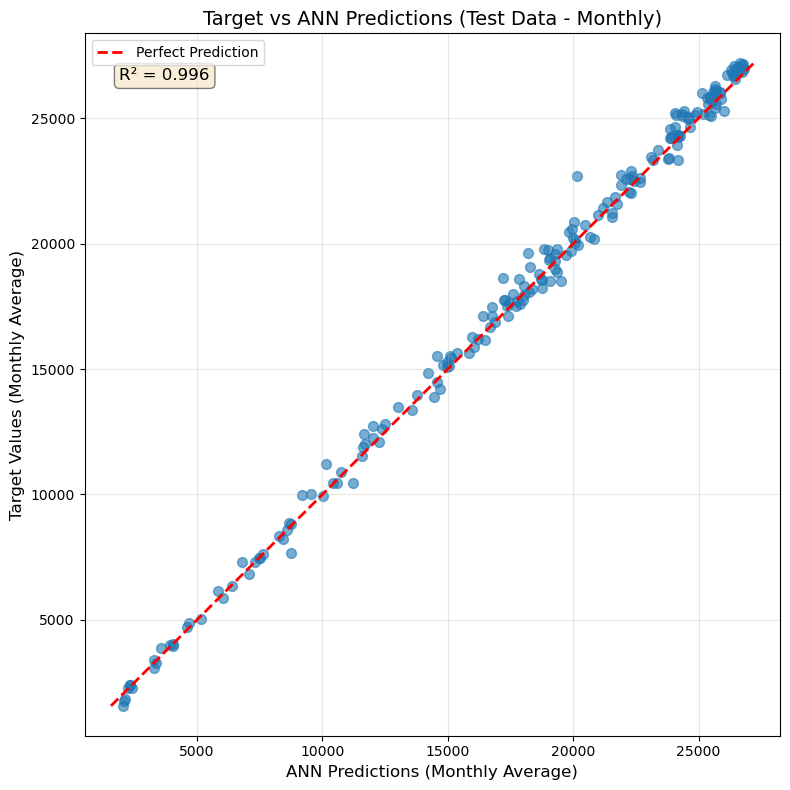

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for monthly test data
y_test_monthly_np = y_test_monthly.values.ravel()
y_test_pred_monthly_np = y_test_pred_monthly.values.ravel()
r2_test_monthly = r2_score(y_test_monthly_np, y_test_pred_monthly_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_pred_monthly_np, y_test_monthly_np, alpha=0.6, s=50)

# Add diagonal line (perfect prediction)
min_val = min(y_test_monthly_np.min(), y_test_pred_monthly_np.min())
max_val = max(y_test_monthly_np.max(), y_test_pred_monthly_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_test_monthly:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions (Monthly Average)', fontsize=12)
plt.ylabel('Target Values (Monthly Average)', fontsize=12)
plt.title('Target vs ANN Predictions (Test Data - Monthly)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Save the final model

In [50]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

# Create station-specific save path
model_save_path = f'./Export/{target}'
os.makedirs(model_save_path, exist_ok=True)

annec.save_model(model, model_save_path)

# Also save the inference model (with inverse scaling built-in)
inference_model_path = os.path.join(model_save_path, 'inference_model')
inference_model.save(inference_model_path)

print(f"Training model (scaled output) saved at: {model_save_path}")
print(f"Inference model (original units) saved at: {inference_model_path}")
print(f"\nTarget station: {target}")
print("\nNote: All scaling layers are now built into the TensorFlow model!")
print("- Output scaling [0.1, 0.9] is applied to EC predictions during training")
print("- Inference model automatically inverse-scales outputs to original EC units")

INFO:tensorflow:Assets written to: ./Export/RSAC054_EC\assets
Model saved at location: ./Export/RSAC054_EC
INFO:tensorflow:Assets written to: ./Export/RSAC054_EC\inference_model\assets
Training model (scaled output) saved at: ./Export/RSAC054_EC
Inference model (original units) saved at: ./Export/RSAC054_EC\inference_model

Target station: RSAC054_EC

Note: All scaling layers are now built into the TensorFlow model!
- Output scaling [0.1, 0.9] is applied to EC predictions during training
- Inference model automatically inverse-scales outputs to original EC units


In [51]:
# Load saved models with custom layers
custom_objects = {
    'MinMaxScaleLayer': annec.MinMaxScaleLayer,
    'InverseMinMaxScaleLayer': annec.InverseMinMaxScaleLayer
}

# Load training model (outputs scaled [0.1, 0.9])
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects=custom_objects)

# Load inference model (outputs original units)
inference_model_path = os.path.join(model_save_path, 'inference_model')
loaded_inference_model = tf.keras.models.load_model(inference_model_path, custom_objects=custom_objects)

# Calculate metrics using inference model (original units)
metrics = []

# Predict with scaled model
y_train_pred_scaled = loaded_model.predict(X_train, verbose=0)
y_test_pred_scaled = loaded_model.predict(X_test, verbose=0)

# Predict with inference model (original units)
y_train_pred = loaded_inference_model.predict(X_train, verbose=0)
y_test_pred = loaded_inference_model.predict(X_test, verbose=0)

print("=== Loaded Models Evaluation ===")
print(f"Training model output range (scaled):  [{y_train_pred_scaled.min():.4f}, {y_train_pred_scaled.max():.4f}]")
print(f"Inference model output range (original): [{y_train_pred.min():.1f}, {y_train_pred.max():.1f}]")

metrics.append(annec.calculate_metrics('ANN (Loaded)', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(df3)

=== Loaded Models Evaluation ===
Training model output range (scaled):  [0.1321, 0.8974]
Inference model output range (original): [1548.4, 27681.1]
          Model  Train_R2  Train_RMSE  Train_Percentage_Bias  Test_R2  \
0  ANN (Loaded)     0.998      382.55                   1.32    0.993   

   Test_RMSE  Test_Percentage_Bias  
0     598.24                  -0.6  


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [52]:
# Load saved models with custom layers
custom_objects = {
    'MinMaxScaleLayer': annec.MinMaxScaleLayer,
    'InverseMinMaxScaleLayer': annec.InverseMinMaxScaleLayer
}

# Load inference model (outputs original units directly)
inference_model_path = os.path.join(model_save_path, 'inference_model')
loaded_inference_model = tf.keras.models.load_model(inference_model_path, custom_objects=custom_objects)

# Load sample: 118 rows × 7 columns (one column per predictor)
df_sample = pd.read_csv("Inputs/selected_EC_7_feature.csv")
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]

print(f"Sample shape: {df_sample.shape}")  # Should be (118, 7)

# Build input list: 7 arrays, each (1, 118)
X_sample = [df_sample[p].to_numpy().reshape(1, 118) for p in predictors]

print(f"Input shapes: {[x.shape for x in X_sample]}")

# Save reshaped data: 7 rows × 118 columns (one row per predictor)
df_reshaped = pd.DataFrame(
    data=[df_sample[p].to_numpy() for p in predictors],
    index=predictors
)
df_reshaped.to_csv("Inputs/selected_EC_7_feature_reshaped.csv", header=False)
print(f"\nReshaped CSV saved: Inputs/selected_EC_7_feature_reshaped.csv")
print(f"Shape: {df_reshaped.shape} (7 predictors × 118 days)")

# Predict with inference model (outputs in original EC units)
y_sample_pred = loaded_inference_model.predict(X_sample, verbose=0)

print(f"\n=== Prediction Results ===")
print(f"Predicted EC (original units): {y_sample_pred[0, 0]:.1f}")
print(f"\nNote: All scaling is handled internally by the model:")
print(f"  1. Input raw values → antecedents and z-score normalization")
print(f"  2. Model inference")
print(f"  3. Output inverse-scaled back to original EC units")

Sample shape: (118, 7)
Input shapes: [(1, 118), (1, 118), (1, 118), (1, 118), (1, 118), (1, 118), (1, 118)]

Reshaped CSV saved: Inputs/selected_EC_7_feature_reshaped.csv
Shape: (7, 118) (7 predictors × 118 days)

=== Prediction Results ===
Predicted EC (original units): 20485.6

Note: All scaling is handled internally by the model:
  1. Input raw values → antecedents and z-score normalization
  2. Model inference
  3. Output inverse-scaled back to original EC units
